# Street Fighter Tester Notebook

# Setup Sonic

In [1]:
import retro

In [2]:
from gym import Env
from gym.spaces import Discrete, Box, MultiBinary
import numpy as np
import cv2

In [3]:
import torch
print(torch.cuda.is_available())

False


In [4]:
class StreetFighter(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)
        self.action_space = MultiBinary(12)
        self.game = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', use_restricted_actions=retro.Actions.FILTERED)
        #self.score = 0
    
    def step(self, action):
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs)
        
        # Preprocess frame from game
        frame_delta = obs 
        
        # Shape reward
        # reward = info['score'] - self.score
        # reward = (self.enemy_health - info['enemy_health'])*2 + (info['health'] - self.health) 
        reward = (self.enemy_health - info['enemy_health'])*3 + (info['health'] - self.health) + info['score'] - self.score 

        return frame_delta, reward, done, info 
    
    def render(self, *args, **kwargs): 
        self.game.render(*args, **kwargs)
    
    def reset(self):
        self.previous_frame = np.zeros(self.game.observation_space.shape)
        
        # Frame delta
        obs = self.game.reset()
        obs = self.preprocess(obs)
        self.previous_frame = obs
        self.health = 176
        self.enemy_health = 176
        
        # Create initial variables
        self.score = 0

        return obs
    
    def preprocess(self, observation): 
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (84,84,1))
        return state
    
    def close(self): 
        self.game.close()

In [5]:
import time
# Import PPO for algos
from stable_baselines3 import PPO
# Evaluate Policy
from stable_baselines3.common.evaluation import evaluate_policy
# Import Wrappers
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, VecTransposeImage

In [6]:
#5.46m is the model that performed best 6.16m pretty good as well
model = PPO.load('best_model_5460000.zip')
# model = PPO.load('trial_0_best_model.zip')
# model = PPO.load('best_model_10000.zip')

In [7]:
env = StreetFighter()
env = Monitor(env)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [14]:
for episode in range(1): 
    obs = env.reset()
    done = False
    # total_reward = 0
    total_score = 0
    final_score = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        env.render()
        time.sleep(0.008)
        score = info[0]['score']
        total_score += score
        final_score = score
    print('Total Score for episode {} is {}'.format(episode, total_score))
    print('Final Score for episode {} is {}'.format(episode, final_score))
    # time.sleep(2)

KeyboardInterrupt: 

In [ ]:
env.close()

#### For simple reward function, which simply gets the difference between the scores of the previoud and current frame

Ep1 - 54900

Ep2 - 27700

Ep3 - 82900

#### For Custom Reward Function, which encourages the AI by giving higher rewards for reducing the enemy's health and deducts rewards when AI takes damage
> reward = (self.enemy_health - info['enemy_health'])*2 + (info['health'] - self.health)

Ep 1 - 107500

Ep 2 - 59500

Ep 3 - 88400

#### For Custom Reward Function, which encourages the AI by giving higher rewards for reducing the enemy's health and deducts rewards when AI takes damage (more agressive) and considers score
> reward = (self.enemy_health - info['enemy_health'])*3 + (info['health'] - self.health) + info['score'] - self.score 

Ep 1 - 65000

Ep 2 - 153500

Ep 3 - 168700

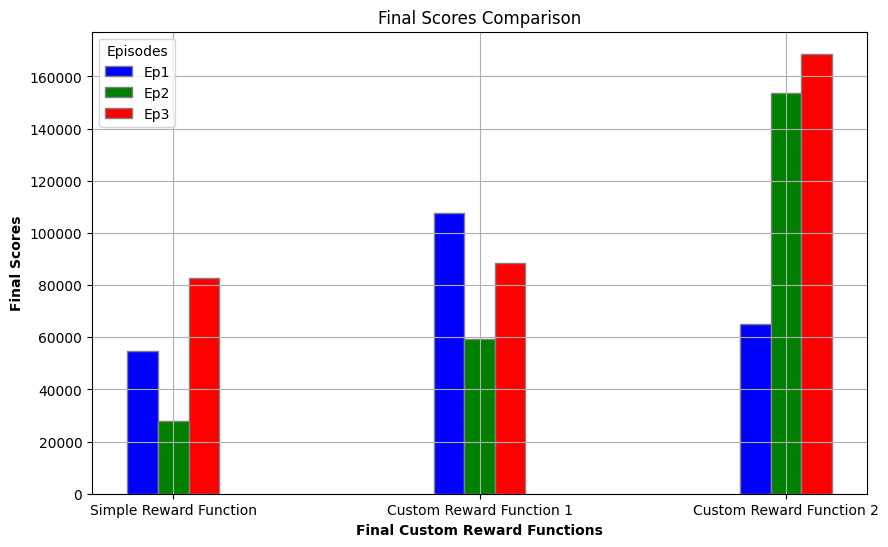

In [4]:
import numpy as np
import matplotlib.pyplot as plt

reward_functions = ['Simple Reward Function', 'Custom Reward Function 1', 'Custom Reward Function 2']

rewards_ep1 = [54900, 107500, 65000]
rewards_ep2 = [27700, 59500, 153500]
rewards_ep3 = [82900, 88400, 168700]

r = np.arange(len(reward_functions))

bar_width = 0.1

plt.figure(figsize=(10, 6))
plt.bar(r, rewards_ep1, color='b', width=bar_width, edgecolor='grey', label='Ep1')
plt.bar(r + bar_width, rewards_ep2, color='g', width=bar_width, edgecolor='grey', label='Ep2')
plt.bar(r + (2 * bar_width), rewards_ep3, color='r', width=bar_width, edgecolor='grey', label='Ep3')

plt.xlabel('Final Custom Reward Functions', fontweight='bold')
plt.ylabel('Final Scores', fontweight='bold')
plt.title('Final Scores Comparison')

plt.xticks([r + bar_width for r in range(len(reward_functions))], reward_functions)
plt.legend(title='Episodes')
plt.grid(True)
plt.show()